In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2,os
from scipy import io
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from tifffile import imread,imwrite
pi = np.pi

In [2]:
rootdir = 'CHANGEME'
outdir = 'CHANGEME'
src = rootdir + 'images/Vz_60/Oct12/'
calibpath = rootdir + 'camera_data/'

os.listdir(src)
os.listdir(calibpath)

['insta2_spectral_sensitivity.mat',
 'insta2_camIntrinsics_water.mat',
 'insta1_camIntrinsics_water.mat',
 'insta1_spectral_sensitivity.mat',
 'insta1_mtf.mat',
 'insta2_mtf.mat',
 'insta2_pixel_value_LUT.mat',
 'insta1_pixel_value_LUT.mat',
 'dive_case_proj_clipped.npz',
 'equirectangular_projmaps.npz',
 'insta1_spherical_coordinates_water_xyz.mat',
 'insta2_spherical_coordinates_water_xyz.mat',
 '.DS_Store',
 'dive_case_image.png',
 'README']

In [3]:
# calibration

# get the correct camera
insta1dates = ['Oct16','Oct17','Oct18','Oct19']
insta2dates = ['Oct12', 'Oct13', 'Oct14','Oct15']
def getinsta(filename):
    insta = -1
    for date in insta1dates:
        if date in filename:
            insta = 1
    for date in insta2dates:
        if date in filename:
            if insta == 1:
                print(f'error in getinsta on {filename}')
            insta = 2
    return insta
sig1 = 3
sig2 = 2

# pixel values to luminance
LUT01 = io.loadmat(calibpath+'insta1_pixel_value_LUT.mat')
LUT02 = io.loadmat(calibpath+'insta2_pixel_value_LUT.mat')
LUT1 = np.stack([LUT01['R_response_LUT'][0],LUT01['G_response_LUT'][0],LUT01['B_response_LUT'][0]],axis=-1)
LUT2 = np.stack([LUT02['R_response_LUT'][0],LUT02['G_response_LUT'][0],LUT02['B_response_LUT'][0]],axis=-1)
def lummap(im,insta):
    if insta == 1:
        lum = np.stack([cv2.LUT((im[:,:,i]).astype('uint8'),LUT1[:,i]) for i in range(3)],axis=-1).astype('float32')
    else:
        lum = np.stack([cv2.LUT((im[:,:,i]).astype('uint8'),LUT2[:,i]) for i in range(3)],axis=-1).astype('float32')
    return lum

# pixel location to world location
case = np.load(calibpath+'dive_case_proj_clipped.npz')['case']
case[case==0] = np.nan
projmaps = np.load(calibpath+'equirectangular_projmaps.npz')['projmaps']

# reproject to azimuth and elevation
def projim(filename,lum=True):
    insta = getinsta(filename)
    im = cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    for c in range(3):
        im[:,:1504,c] = gaussian_filter(im[:,:1504,c],sig1)
        im[:,1504:,c] = gaussian_filter(im[:,1504:,c],sig2)
    out = np.zeros_like(im)
    out[:,:1504,:] = cv2.remap(np.rot90(im[:,:1504,:],3),projmaps[insta,:,:1504,:],None,interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    out[:,1504:,:] = cv2.remap(np.rot90(im[:,1504:,:],1),projmaps[insta,:,1504:,:],None,interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    if lum:
        out = lummap(out,insta)
        return np.flipud(out)*case
    return (np.flipud(out)*case).astype('uint8')

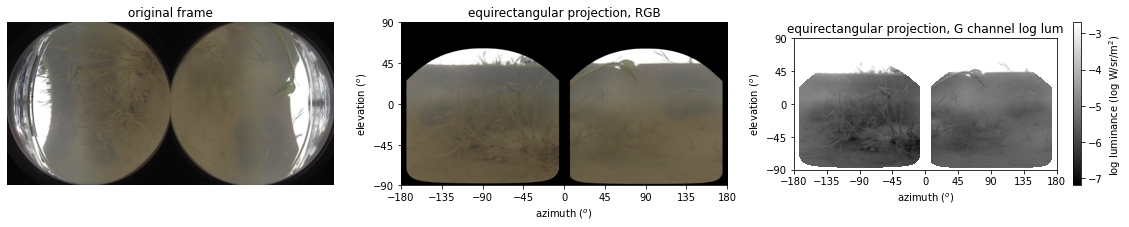

In [4]:
# example
png = src+'729.png'

plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.imshow(plt.imread(png))
plt.axis('off')
plt.title('original frame')
plt.subplot(1,3,2)

projected = projim(png,lum=False) 
plt.imshow(projected,extent=[-180,180,-90,90])
plt.title('equirectangular projection, RGB')
plt.yticks(np.arange(-90,91,45));
plt.xticks(np.arange(-180,181,45));
plt.xlabel('azimuth ($^o$)')
plt.ylabel('elevation ($^o$)')

lumprojected = projim(png) 
plt.subplot(1,3,3)
plt.imshow(np.log(lumprojected[:,:,1]),'gray',extent=[-180,180,-90,90])
plt.title('equirectangular projection, G channel log lum')
plt.colorbar(label='log luminance (log W/sr/m$^2$)')
plt.yticks(np.arange(-90,91,45))
plt.xticks(np.arange(-180,181,45))
plt.xlabel('azimuth ($^o$)')
plt.ylabel('elevation ($^o$)');

In [161]:
# reproject and convert to luminance, save as tiffs
os.makedirs(outdir,exist_ok=True)
frames = os.listdir(src)
for f,frame in enumerate(frames):
    if f%50 == 0:
        print(f,end=' ')
    out = projim(src+frame)
    imwrite(outdir+frame[:-4]+'.tiff',out)

0 50 100 150 200 250 300 350 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


401/400 images converted


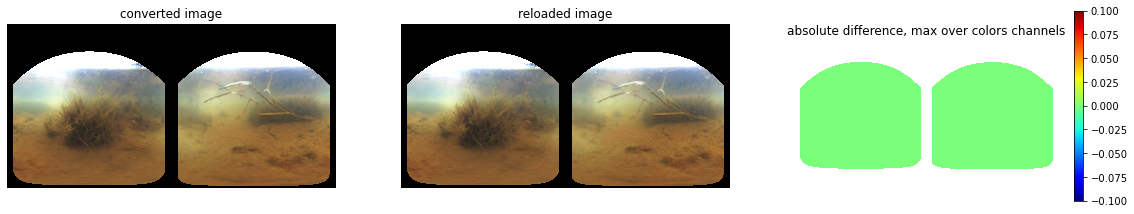

In [35]:
# confirm images saved correctly and that all images were converted

plt.figure(figsize=(20,3.5))
plt.subplot(1,3,1)
plt.imshow(out/np.nanmax(out)*10)
plt.title('converted image')
plt.axis('off')
plt.subplot(1,3,2)
plt.axis('off')
RGBlum = imread(outdir+frames[-1][:-4]+'.tiff')
plt.title('reloaded image')
plt.imshow(RGBlum/np.nanmax(RGBlum)*10)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.max(np.abs(RGBlum-out),axis=-1),'jet')
plt.title('absolute difference, max over colors channels')           
plt.axis('off')
plt.colorbar()
                  
print(f'{len(os.listdir(outdir))}/{len(os.listdir(src))} images converted')

In [ ]:
# convert tiffs to stack for use in ImageJ

from skimage import io

testlen = 100 # each stack gets 100 frames = 1 sec, any longer and there are file opening issues

for s in range(4):
    for i,color in enumerate(['R','G','B']): 

        print('\n'+color)
        stack = np.zeros((testlen,)+np.shape(out)[:-1]).astype('float32')

        k = 0
        for j in range(s*testlen,(s+1)*testlen):#range(len(frames)):
            if (j+1) % 50 == 0:
                print(f'{j+1}/{testlen}',end='\t')
            im = io.imread(outdir+frames[j][:-4]+'.tiff')[:,:,i]
            stack[k,:,:]= im
            k = k+1
            
        io.imsave(f'{outdir}stack{color}{s+1}.tiff',stack)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 3007.5, 1503.5, -0.5)

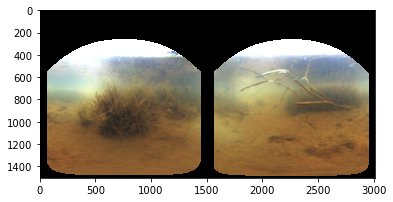

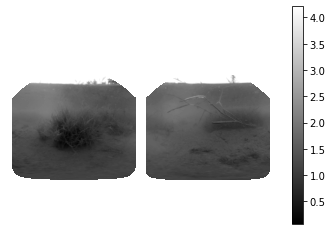

In [66]:
# log luminance - multiply by 1000 to get nonnegative values (may not all be nonnegative, units are log mW/sr/m^2)
plt.imshow(out/np.nanmax(out)*10);
plt.figure()
plt.imshow(np.log(1000*out[:,:,1]),'gray')
plt.colorbar()
plt.axis('off')

In [ ]:
# log luminance stacks for imageJ

testlen = 200 # can do 2 sec at a time before ImageJ gets upset and stops recognizing the file type

for s in range(2):
    for i,color in enumerate(['R','G','B']): 

        print('\n'+color+str(s))
        stack = np.zeros((testlen,)+np.shape(out)[:-1]).astype('float32')

        k = 0
        for j in range(s*testlen,(s+1)*testlen):
            if (j+1) % 50 == 0:
                print(f'{k+1}/{testlen}',end='\t')
            im = io.imread(outdir+frames[j][:-4]+'.tiff')[:,:,i]
            loglum = np.log(1000*im)
            stack[k,:,:]= loglum
            k = k+1

        io.imsave(f'{outdir}logstack{color}{s+1}.tiff',stack)